In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline

In [4]:
DATA_PATH = '/Users/shovitraj/Github/Python/MagNet_data/'

In [5]:
dst = pd.read_csv(DATA_PATH +"dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv(DATA_PATH + "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind = pd.read_csv(DATA_PATH + "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

In [6]:
from numpy.random import seed
from tensorflow.random import set_seed

In [7]:
seed(2020)
set_seed(2021)

In [8]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [9]:
# # subset of solar wind features to use for modeling
# SOLAR_WIND_FEATURES = [ "bx_gse",
#                         "by_gse",
#                         "bz_gse",
#                         "speed",
#                         "density",
#                         "temperature",
#                         "theta_gse" ]

# # all of the features we'll use, including sunspot numbers
# #XCOLS = (
# #    [col + "_mean" for col in SOLAR_WIND_FEATURES]
# #    + [col + "_std" for col in SOLAR_WIND_FEATURES]
# #    + ["smoothed_ssn"]
# #)

# XCOLS = (['bx_gse_mean', 'by_gse_mean', 'bz_gse_mean', 'bz_gse_std',
#           'speed_mean', 'speed_std', 'density_mean', 'smoothed_ssn'])

# def impute_features(feature_df):
#     """Imputes data using the following methods:
#     - `smoothed_ssn`: forward fill
#     - `solar_wind`: interpolation
#     """
#     # forward fill sunspot data for the rest of the month
#     feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
#     # interpolate between missing solar wind values
#     feature_df = feature_df.interpolate()
#     return feature_df


# def aggregate_hourly(feature_df, aggs=["mean", "std"]):
#     """Aggregates features to the floor of each hour using mean and standard deviation.
#     e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
#     """
#     # group by the floor of each hour use timedelta index
#     agged = feature_df.groupby(
#         ["period", feature_df.index.get_level_values(1).floor("H")]
#     ).agg(aggs)
#     # flatten hierachical column index
#     agged.columns = ["_".join(x) for x in agged.columns]
#     return agged


# def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
#     """
#     Preprocessing steps:
#         - Subset the data
#         - Aggregate hourly
#         - Join solar wind and sunspot data
#         - Scale using standard scaler
#         - Impute missing values
#     """
#     # select features we want to use
#     if subset:
#         solar_wind = solar_wind[subset]

#     # aggregate solar wind data and join with sunspots
#     hourly_features = aggregate_hourly(solar_wind).join(sunspots)
#     hourly_xcols = hourly_features[XCOLS]
#     # subtract mean and divide by standard deviation
#     if scaler is None:
#         scaler = StandardScaler()
#         scaler.fit(hourly_xcols)

#     normalized = pd.DataFrame(
#         scaler.transform(hourly_xcols),
#         index=hourly_xcols.index,
#         columns=hourly_xcols.columns,
#     )

#     # impute missing values
#     imputed = impute_features(normalized)

#     # we want to return the scaler object as well to use later during prediction
#     return imputed, scaler

In [10]:
# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
    "temperature",
    'theta_gse',
    'phi_gse'
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


XCOLS_NEW = (['bx_gse_mean', 'by_gse_mean', 'bz_gse_mean', 'bz_gse_std',
          'speed_mean', 'speed_std', 'density_mean', 'smoothed_ssn'])

def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)
    hourly_xcols = hourly_features[XCOLS_NEW]

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_xcols)

    normalized = pd.DataFrame(
        scaler.transform(hourly_xcols),
        index=hourly_xcols.index,
        columns=hourly_xcols.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler
   

In [11]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 8)


bx_gse_mean  by_gse_mean  bz_gse_mean  bz_gse_std  \
period  timedelta                                                            
train_a 0 days 00:00:00    -1.599207     0.419516     0.300358   -0.651645   
        0 days 01:00:00    -1.757995     0.179257     0.446103   -0.517913   
        0 days 02:00:00    -1.912116     0.183266     0.770174   -0.876490   
        0 days 03:00:00    -1.809045    -0.378111     0.621194   -0.290211   
        0 days 04:00:00    -1.338802     0.072745     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  smoothed_ssn  
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827      0.139444  
        0 days 01:00:00   -0.986904   0.995063     -0.861692      0.139444  
        0 days 02:00:00   -1.013548   0.554085     -0.846222      0.139444  
        0 days 03:00:00   -0.826469  -0.211185     -0.404306      0.139444  
        0 days 04:00:00   -0.601238   1.016033     -0.371487      0.139444

In [12]:
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()

In [13]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

In [14]:
data = labels.join(features)
data.head()

t0    t1  bx_gse_mean  by_gse_mean  bz_gse_mean  \
period  timedelta                                                          
train_a 0 days 00:00:00  -7 -10.0    -1.599207     0.419516     0.300358   
        0 days 01:00:00 -10 -10.0    -1.757995     0.179257     0.446103   
        0 days 02:00:00 -10  -6.0    -1.912116     0.183266     0.770174   
        0 days 03:00:00  -6  -2.0    -1.809045    -0.378111     0.621194   
        0 days 04:00:00  -2   3.0    -1.338802     0.072745     0.467629   

                         bz_gse_std  speed_mean  speed_std  density_mean  \
period  timedelta                                                          
train_a 0 days 00:00:00   -0.651645   -0.738546   0.862524     -0.775827   
        0 days 01:00:00   -0.517913   -0.986904   0.995063     -0.861692   
        0 days 02:00:00   -0.876490   -1.013548   0.554085     -0.846222   
        0 days 03:00:00   -0.290211   -0.826469  -0.211185     -0.404306   
        0 days 04:00:00   -0.478080   -0.601238   1.016033     -0.371487   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [15]:
data=data[['t0', 't1','bx_gse_mean', 'by_gse_mean',
       'bz_gse_mean', 'bz_gse_std', 'speed_mean', 'speed_std', 'density_mean',
        'smoothed_ssn']]

In [16]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=6_000)


In [17]:
XCOLS=data.columns
XCOLS

Index(['t0', 't1', 'bx_gse_mean', 'by_gse_mean', 'bz_gse_mean', 'bz_gse_std',
       'speed_mean', 'speed_std', 'density_mean', 'smoothed_ssn'],
      dtype='object')

In [18]:
data_config = {
    "timesteps": 138,
    "batch_size":138,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 748
Number of val batches: 126


In [19]:
print(data.shape)

(139872, 10)


In [20]:
# define our model
from tensorflow.keras.layers import Dropout
model_config = {"n_epochs": 90, "n_neurons": 32,
                  "dropout": 0.4, "stateful": False}

def models():
  
    model = Sequential()
    model.add(
      LSTM(
          model_config["n_neurons"],
          # usually set to (batch_size, sequence_length, n_features)
          # setting the batch size to None allows for variable length batches
          batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
          stateful=model_config["stateful"],
          kernel_regularizer='l2',
      )
  )
 
    model.add(Dense(32,kernel_regularizer='l2'))
    model.add(Dropout(0.4))
    model.add(Dense(32,kernel_regularizer='l2'))
    model.add(Dropout(0.4))
  #model.add(Dense())
    model.add(Dense(len(YCOLS)))
    opt=Adam(learning_rate=0.00001)
    model.compile(
      loss="mean_squared_error",
      optimizer=opt,
    )
    return model

model_final4=models()
model_final4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5504      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 7,682
Trainable params: 7,682
Non-trainable params: 0
______________________________________________________

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history_final4 = model_final4.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=1,
    shuffle=False,
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/90
748/748 [==============================] - 42s 54ms/step - loss: 604.2795 - val_loss: 491.7629
Epoch 2/90
748/748 [==============================] - 36s 49ms/step - loss: 581.2033 - val_loss: 471.5912
Epoch 3/90
748/748 [==============================] - 38s 50ms/step - loss: 551.1778 - val_loss: 445.0203
Epoch 4/90
748/748 [==============================] - 47s 63ms/step - loss: 513.7193 - val_loss: 413.3471
Epoch 5/90
748/748 [==============================] - 45s 60ms/step - loss: 470.9299 - val_loss: 382.0183
Epoch 6/90
748/748 [==============================] - 48s 64ms/step - loss: 430.7098 - val_loss: 353.4606
Epoch 7/90
748/748 [==============================] - 51s 68ms/step - loss: 394.3636 - val_loss: 328.3347
Epoch 8/90
748/748 [==============================] - 50s 66ms/step - loss: 362.2748 - val_loss: 306.1612
Epoch 9/90
748/748 [==============================] - 49s 66ms/step - loss: 333.4778 - val_loss: 286.5801
Epoch 10/90
748/748 [=========================

748/748 [==============================] - 36s 48ms/step - loss: 52.4107 - val_loss: 48.5247
Epoch 79/90
748/748 [==============================] - 37s 49ms/step - loss: 51.2727 - val_loss: 47.8947
Epoch 80/90
748/748 [==============================] - 40s 53ms/step - loss: 50.5184 - val_loss: 47.1614
Epoch 81/90
748/748 [==============================] - 41s 55ms/step - loss: 50.2589 - val_loss: 46.7547
Epoch 82/90
748/748 [==============================] - 39s 52ms/step - loss: 51.5306 - val_loss: 46.1984
Epoch 83/90
748/748 [==============================] - 43s 58ms/step - loss: 49.5366 - val_loss: 45.4514
Epoch 84/90
748/748 [==============================] - 39s 53ms/step - loss: 48.2533 - val_loss: 45.0358
Epoch 85/90
748/748 [==============================] - 40s 53ms/step - loss: 49.7660 - val_loss: 44.1887
Epoch 86/90
748/748 [==============================] - 37s 49ms/step - loss: 47.7125 - val_loss: 43.4761
Epoch 87/90
748/748 [==============================] - 37s 49ms/ste

126/126 [==============================] - 3s 25ms/step - loss: 50.6590
Test RMSE: 7.1175


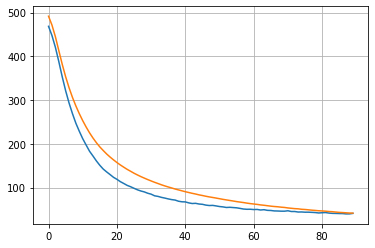

In [22]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
mse = model_final4.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.4f}")
for name, values in history_final4.history.items():
    plt.plot(values)
    plt.grid("True")


In [23]:
train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
tmse = model_final4.evaluate(train_ds)
print(f"Train RMSE: {tmse**.5:.4f}")

748/748 [==============================] - 19s 25ms/step - loss: 18.9397
Train RMSE: 4.3520


In [24]:
import json
import pickle

model_final4.save("model")

with open("scaler.pck", "wb") as f:
    pickle.dump(scaler, f)

data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
print(data_config)
with open("config.json", "w") as f:
    json.dump(data_config, f)

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


{'timesteps': 138, 'batch_size': 138, 'solar_wind_subset': ['bx_gse', 'by_gse', 'bz_gse', 'speed', 'density', 'temperature', 'theta_gse', 'phi_gse']}
